# A definitive guide to effect size

## Setup

In [3]:
import pandas as pd
import numpy as np
import pingouin as pg
from scipy import stats
import statsmodels.api as sm

# plotting
import seaborn as sns 
import matplotlib.pyplot as plt

plt.style.use('seaborn')

In [4]:
%config InlineBackend.figure_format = 'retina'

## Effect size families

### 1. The "correlation" family

In [25]:
# define the parameters
nobs = 10**5
mu = [1, 1.5]
cov_matrix = np.array([[1, 0.6],
                      [0.6, 1]])

# generate the correlated random variables 
np.random.seed(42)
x = np.random.multivariate_normal(mu, cov_matrix, size=nobs)

#### Pearson's r

In [6]:
np.corrcoef(x, rowvar=False)

array([[1.        , 0.60236704],
       [0.60236704, 1.        ]])

In [7]:
stats.pearsonr(x[:,0], x[:,1])

(0.6023670412294826, 0.0)

In [8]:
pg.corr(x[:, 0], x[:, 1])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,100000,0.602367,"[0.6, 0.61]",0.362846,0.362833,0.0,inf,1.0


#### Coefficient of determination (R²)

In [9]:
pg.linear_regression(x[:, 0], x[:, 1])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.893873,0.003561,251.004199,0.0,0.362846,0.36284,0.886894,0.900853
1,x1,0.601396,0.002520,238.635290,0.0,0.362846,0.36284,0.596457,0.606336


In [10]:
X = sm.add_constant(x[:, 0])
model = sm.OLS(x[:, 1], X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                 5.695e+04
Date:                Tue, 16 Jun 2020   Prob (F-statistic):               0.00
Time:                        00:26:16   Log-Likelihood:            -1.1938e+05
No. Observations:              100000   AIC:                         2.388e+05
Df Residuals:                   99998   BIC:                         2.388e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8939      0.004    251.004      0.000       0.887       0.901
x1             0.6014      0.003    238.635      0.000       0.596       0.606
==============================================================================
Omnibus:                        1.991   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.370   Jarque-Bera (JB):                1.982
Skew:                          -0.003   Prob(JB):                        0.371
Kurtosis:                       2.979   Cond. No.                         2.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Eta-squared

In [11]:
pg.compute_effsize(x[:, 0], x[:, 1], eftype='eta-square')

0.057968511053166284

### 2. The "difference" family

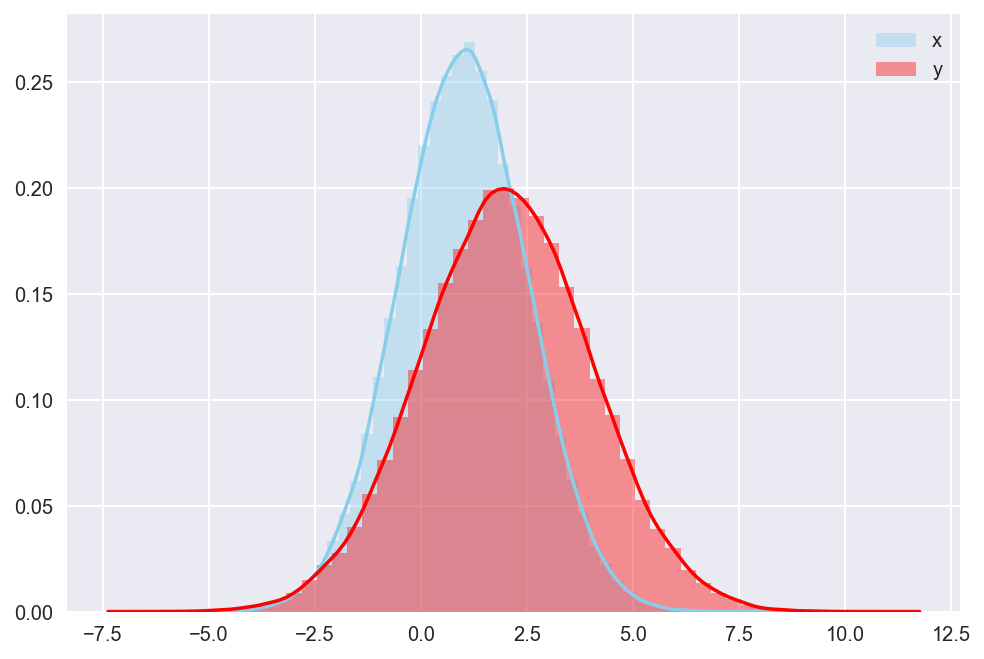

In [12]:
# define the parameters
nobs = 10**5

# generate the random variables 
np.random.seed(42)
x = np.random.normal(1, 1.5, nobs)
y = np.random.normal(2, 2, nobs)

# plot the variables
sns.distplot(x, color="skyblue", label="x")
sns.distplot(y, color="red", label="y")
plt.legend()

#### Cohen's d

In [13]:
pg.compute_effsize(x, y, eftype='cohen')

-0.5661743543595718

#### Glass' Δ

In [14]:
pg.compute_effsize(x, y, eftype='glass')

-0.6664041092152272

#### Hedges' g

In [15]:
pg.compute_effsize(x, y, eftype='hedges')

-0.5661722311818571

### 3. The "categorical" family

In [16]:
# define the parameters
nobs = 10**4
choices = [0, 1]

# generate the random variables 
np.random.seed(42)
x = np.random.choice(choices, size=nobs, p=[0.5, 0.5])
y = np.random.choice(choices, size=nobs, p=[0.6, 0.4])

#### φ (phi coefficient)

In [23]:
from sklearn.metrics import matthews_corrcoef

def get_phi_coeff(x, y):
    n = len(x)
    cont_table = pd.crosstab(x, y)
    chi_2 = stats.chi2_contingency(cont_table, correction=False)[0]
    phi = np.sqrt(chi_2 / n)
    return phi

phi = get_phi_coeff(x, y)
mcc = matthews_corrcoef(x, y)
r = stats.pearsonr(x, y)[0]

print(f'Phi coefficient: {phi:.6f}')
print(f"Matthews Correlation: {mcc:.6f}")
print(f"Pearson's r: {r:.6f}")

Phi coefficient: 0.000944
Matthews Correlation: 0.000944
Pearson's r: 0.000944


#### Cramér's V

In [18]:
def get_cramer_v(x, y):
    n = len(x)
    cont_table = pd.crosstab(x, y)
    chi_2 = stats.chi2_contingency(cont_table, correction=False)[0]
    v = np.sqrt(chi_2 / (n * (np.min(cont_table.shape) - 1)))
    return v

cramer_v = get_cramers_v(x, y)

print(f"Cramer's V: {cramer_v:.6f}")

Cramer's V: 0.000944


#### Cohen's w

In [19]:
from statsmodels.stats.gof import chisquare_effectsize

cohen_w = chisquare_effectsize([np.sum(x), np.sum(x == 0)], 
                               [np.sum(y), np.sum(y == 0)])
print(f"Cohen's w: {cohen_w:.6f}")

Cohen's w: 0.173820


#### Cohen's h

In [20]:
from statsmodels.stats.proportion import proportion_effectsize

cohen_h = proportion_effectsize(np.mean(x), np.mean(y))
print(f"Cohen's h: {cohen_h:.6f}")

Cohen's h: 0.174943


#### Odds Ratio

In [21]:
odds_ratio = pg.compute_effsize(x, y, eftype='odds-ratio')
print(f"Odds Ratio: {odds_ratio:.6f}")

Odds Ratio: 1.374506


#### Common Language Effect Size

CLES: 0.779395


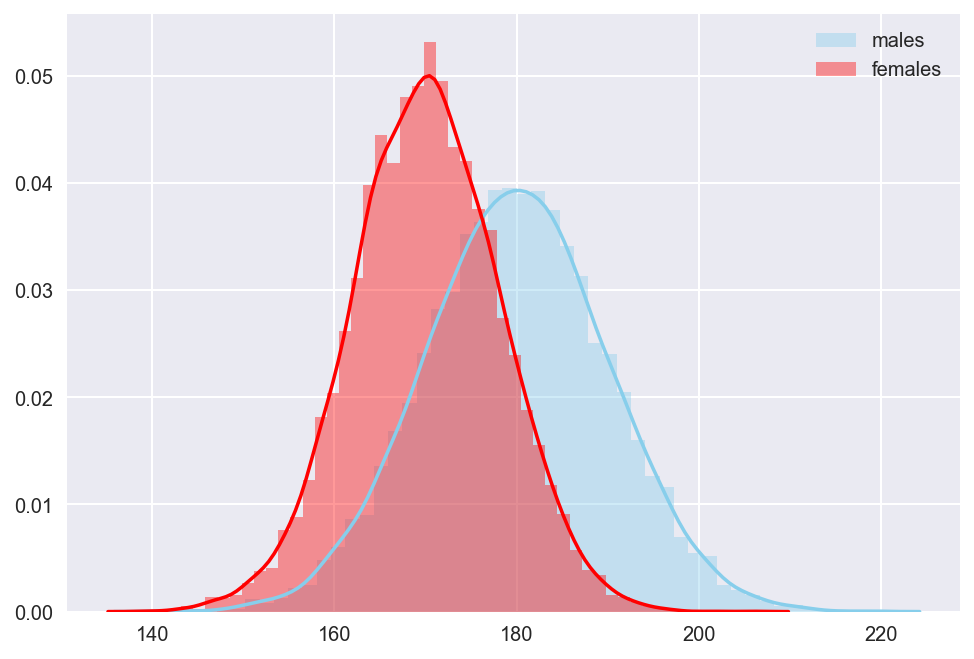

In [24]:
# define the parameters
nobs = 10**4

# generate the random variables 
np.random.seed(42)
males = np.random.normal(180, 10, nobs)
females = np.random.normal(170, 8, nobs)

# plot the variables
sns.distplot(males, color="skyblue", label="males")
sns.distplot(females, color="red", label="females")
plt.legend()

cles = pg.compute_effsize(males, females, eftype='CLES')
print(f"CLES: {cles:.6f}")